In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'WETH-USDT-3000'
NUMERAIRE_TOKEN = 1
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'  # change to 'H' if you want hourly pool snapshots
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159300 entries, 0 to 159299
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   swap_time                       159300 non-null  datetime64[ns, UTC]
 1   tx_hash                         159300 non-null  string             
 2   token_0_amount                  159300 non-null  float64            
 3   token_1_amount                  159300 non-null  float64            
 4   pool_address                    159300 non-null  string             
 5   price_tick                      159300 non-null  int64              
 6   price_tick_adjusted             159300 non-null  float64            
 7   contract_address_token_0        159300 non-null  string             
 8   contract_name_token_0           159300 non-null  string             
 9   contract_ticker_symbol_token_0  159300 non-null  string             
 

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:38:25+00:00,0xb58884e3560cee63ddd0c39e2a696e11e7063eae7343...,1.300000,-3365.995893,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,-197700,2596.7334,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,3000,60,2021-05-05 16:37:08+00:00
1,2022-01-29 19:34:12+00:00,0x57c4af9974e06df4a4c4e2a6ce8bf5dc02b7acb6ba3d...,0.900000,-2330.387545,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,-197699,2596.9931,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,3000,60,2021-05-05 16:37:08+00:00
2,2022-01-29 19:33:47+00:00,0x4c1d78307666a4c4539167cac29ff357e58ec811668b...,-54.511652,141875.800000,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,-197699,2596.9931,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,3000,60,2021-05-05 16:37:08+00:00
3,2022-01-29 19:03:52+00:00,0xc37a76b1d1159e67379d07c6e4a7a83cfb01aed84bec...,-0.270085,702.320627,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,-197717,2592.3229,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,3000,60,2021-05-05 16:37:08+00:00
4,2022-01-29 18:56:20+00:00,0x2d66d97aff5d1191ba9dd8afe50077fcfbcb18c7f8fe...,-1.305730,3395.289643,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,-197717,2592.3229,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,3000,60,2021-05-05 16:37:08+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29092 entries, 0 to 29091
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        29092 non-null  datetime64[ns, UTC]
 1   tx_hash                         29092 non-null  string             
 2   token_0_amount                  29092 non-null  float64            
 3   token_1_amount                  29092 non-null  float64            
 4   pool_address                    29092 non-null  string             
 5   liquidity_event                 29092 non-null  string             
 6   price_tick_lower                29092 non-null  int64              
 7   price_tick_upper                29092 non-null  int64              
 8   price_tick_lower_adjusted       29092 non-null  float64            
 9   price_tick_upper_adjusted       29092 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 19:14:38+00:00,0xd5287c2dadd3363992d6231f55fde4fca58312ba486d...,18.345197,0.000000,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,REMOVE_LIQUIDITY,-195840,-192660,3127.5344,4298.3407,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0xc4741d14b08dbd6e9abbe7f14e00406573b63811,3000,60,2021-05-05 16:37:08+00:00,-0.006979
1,2022-01-29 16:56:03+00:00,0xea8f49e7247e0545b92a799d12c781716300551d2cbf...,2.300000,1875.738450,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-198720,-195240,2344.9390,3320.9204,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xda0e9b090fa8559abbfa09ba755ea580b4c3a7e2,3000,60,2021-05-05 16:37:08+00:00,0.000930
2,2022-01-29 08:51:07+00:00,0xad915470dd7474035687edc1c33fcf895058fffb2b35...,6.780760,27165.445673,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-204240,-193980,1350.2462,3766.8371,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x5a6eade27773eab2e4038ec7cf388781eca02f63,3000,60,2021-05-05 16:37:08+00:00,0.001958
3,2022-01-29 08:51:07+00:00,0xad915470dd7474035687edc1c33fcf895058fffb2b35...,42.442571,0.000000,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,REMOVE_LIQUIDITY,-197340,-191160,2691.9140,4993.9220,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0x5a6eade27773eab2e4038ec7cf388781eca02f63,3000,60,2021-05-05 16:37:08+00:00,-0.008284
4,2022-01-29 08:51:07+00:00,0xad915470dd7474035687edc1c33fcf895058fffb2b35...,6.374256,26882.504474,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,REMOVE_LIQUIDITY,-210420,-191160,727.8341,4993.9220,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Burn,0x5a6eade27773eab2e4038ec7cf388781eca02f63,3000,60,2021-05-05 16:37:08+00:00,-0.001137


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-05 16:37:08+00:00,0x2e07c690f149223e4f290986277304ea6a05c6ee47ba...,1.242324e+01,50500.280094,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-197400,-193320,2675.8117,4023.8227,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0xe14722b5f1aa6ea161e547c5ca598068ec1b3bc0,3000,60,2021-05-05 16:37:08+00:00,8.210905e-03
1,2021-05-05 17:20:08+00:00,0x85a3f0ed4fc14085609e95e7366364566b89d7569e62...,1.000000e-03,0.000000,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-195120,-195060,3361.0095,3381.2352,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x726022a9fe1322fa9590fb244b8164936bb00489,3000,60,2021-05-05 16:37:08+00:00,1.935471e-05
2,2021-05-05 17:26:26+00:00,0x0fde2929c1fa5dd5dc9a0fcfbf8adccdeefbc398aa36...,9.995372e-08,0.000274,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-195180,-195120,3340.9048,3361.0095,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x726022a9fe1322fa9590fb244b8164936bb00489,3000,60,2021-05-05 16:37:08+00:00,3.509242e-09
3,2021-05-05 17:29:37+00:00,0x34ca11f7f1c6a4d8d17cabf14c6d0ffa5116a693508c...,9.999750e-06,0.027412,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-195180,-195120,3340.9048,3361.0095,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x726022a9fe1322fa9590fb244b8164936bb00489,3000,60,2021-05-05 16:37:08+00:00,3.510779e-07
4,2021-05-05 17:29:37+00:00,0x9ece74425a9b5b937b51e14d4fbb9eb7aa6f6ae415d5...,9.999750e-06,0.027412,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,ADD_LIQUIDITY,-195180,-195120,3340.9048,3361.0095,...,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether USD,USDT,6,Mint,0x726022a9fe1322fa9590fb244b8164936bb00489,3000,60,2021-05-05 16:37:08+00:00,3.510779e-07


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x2e07c690f149223e4f290986277304ea6a05c6ee47ba303732166bc1b15cbafb


In [8]:
# from https://etherscan.io/tx/0x2e07c690f149223e4f290986277304ea6a05c6ee47ba303732166bc1b15cbafb#eventlog
liquidity_delta = amount_to_float('8210904713296766', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (USDT/WETH): 3.349936990661e-09
Pool initial price (WETH/USDT): 2.985130773468e+08


In [9]:
sqrt_price_x96 = 4585618311359384700632587
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 3.349936990661e-09
Price per Etherscan:      3.349936990655e-09


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,29091,0x2e07c690f149223e4f290986277304ea6a05c6ee47ba...,2021-05-05 16:37:08+00:00,ADD_LIQUIDITY
1,29090,0x85a3f0ed4fc14085609e95e7366364566b89d7569e62...,2021-05-05 17:20:08+00:00,ADD_LIQUIDITY
2,29089,0x0fde2929c1fa5dd5dc9a0fcfbf8adccdeefbc398aa36...,2021-05-05 17:26:26+00:00,ADD_LIQUIDITY
3,29087,0x9ece74425a9b5b937b51e14d4fbb9eb7aa6f6ae415d5...,2021-05-05 17:29:37+00:00,ADD_LIQUIDITY
4,29088,0x34ca11f7f1c6a4d8d17cabf14c6d0ffa5116a693508c...,2021-05-05 17:29:37+00:00,ADD_LIQUIDITY
...,...,...,...,...
187847,506,0x8d6b8fc0cc35de23f1696879496061a12455d1f87d20...,2022-01-27 23:49:16+00:00,SWAP
187848,505,0x45bb3bd5f066b7ad266fd8101afa85e02a063526084d...,2022-01-27 23:52:48+00:00,SWAP
187849,504,0x3342198d04071b69d2958709f3bbc717165968ee0690...,2022-01-27 23:53:22+00:00,SWAP
187850,503,0xb5810b58be9ee79c2bd67f9627b9be3b5d26f7a6182d...,2022-01-27 23:53:59+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [ ]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

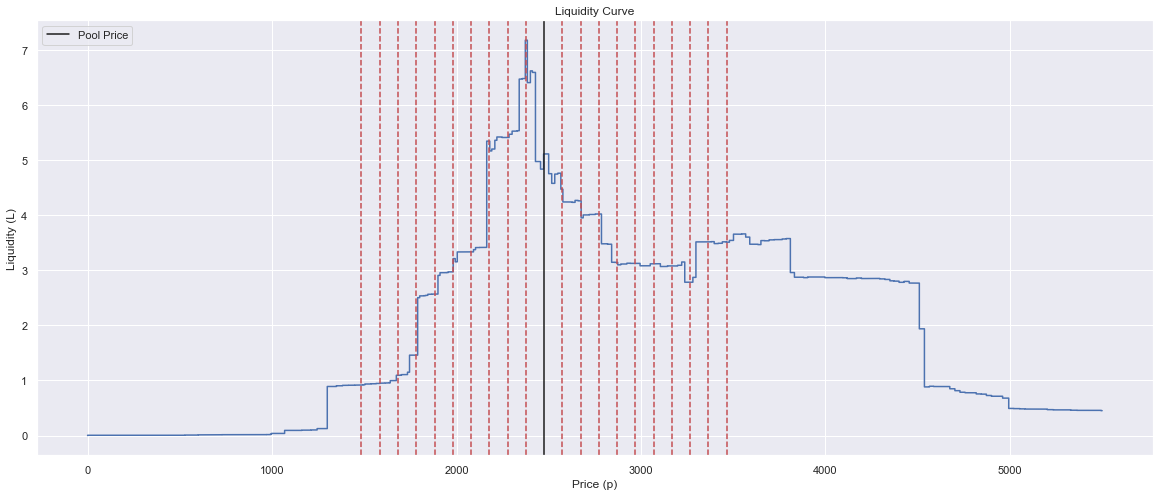

In [13]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 5000), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

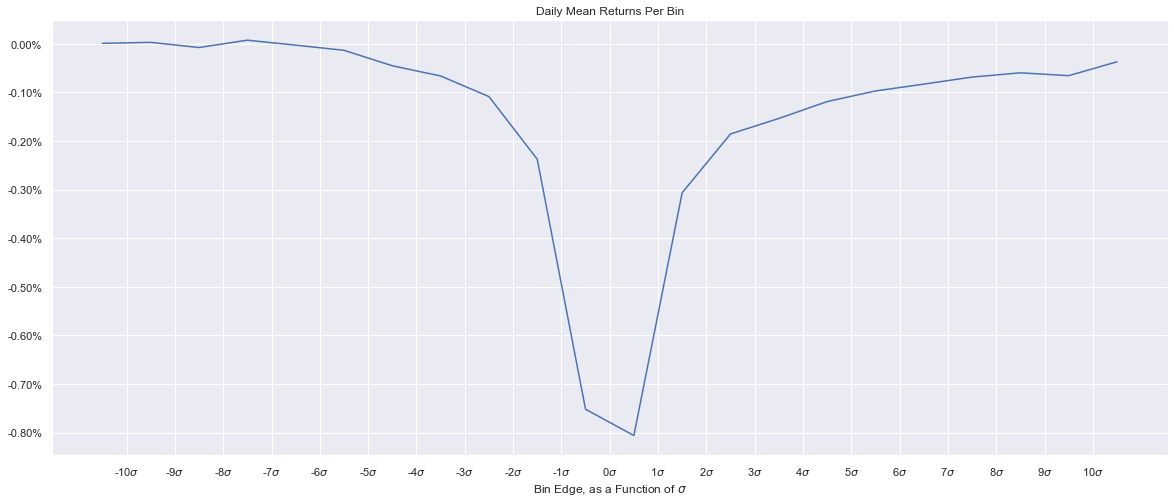

CPU times: user 6min 16s, sys: 9.33 s, total: 6min 26s
Wall time: 6min 30s


In [14]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

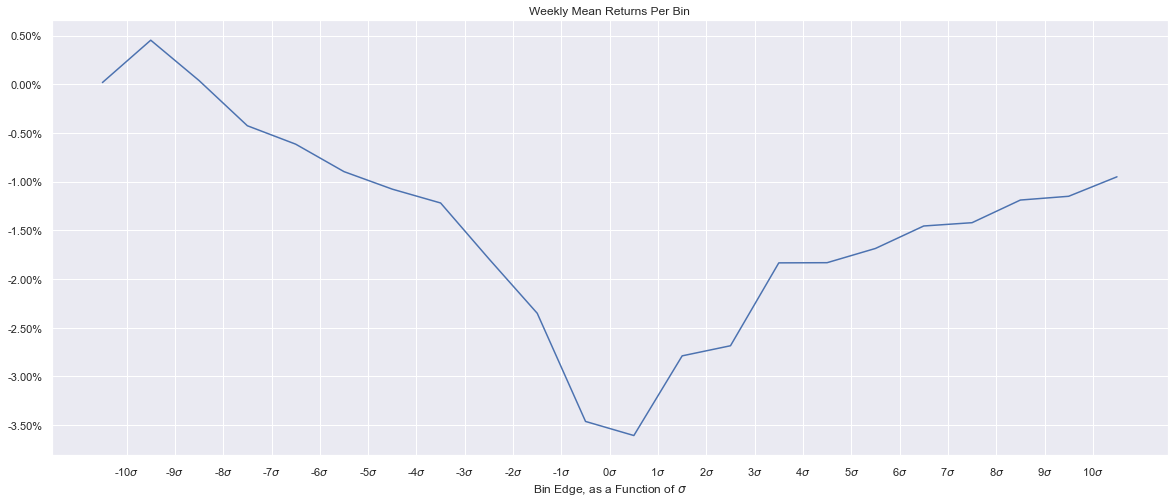

CPU times: user 1min 43s, sys: 2.99 s, total: 1min 46s
Wall time: 1min 47s


In [15]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Weekly Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [16]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Hourly Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()